In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [114]:
df = pd.read_csv('pima-indians-diabetes.csv')

In [115]:
# Handle missing values - impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
print(df_imputed.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      0.0  33.6   
1          1.0     85.0           66.0           29.0      0.0  26.6   
2          8.0    183.0           64.0            0.0      0.0  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          0.0    137.0           40.0           35.0    168.0  43.1   

   DiabetespedigreeFunction   Age  Outcome  
0                     0.627  50.0      1.0  
1                     0.351  31.0      0.0  
2                     0.672  32.0      1.0  
3                     0.167  21.0      0.0  
4                     2.288  33.0      1.0  


In [116]:
# Handle outliers using Z-score (e.g., remove values with z-scores greater than 3)
from scipy import stats
z_scores = np.abs(stats.zscore(df_imputed.select_dtypes(include=[np.number])))
df_no_outliers = df_imputed[(z_scores < 3).all(axis=1)]
print(df_no_outliers.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      0.0  33.6   
1          1.0     85.0           66.0           29.0      0.0  26.6   
2          8.0    183.0           64.0            0.0      0.0  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
5          5.0    116.0           74.0            0.0      0.0  25.6   

   DiabetespedigreeFunction   Age  Outcome  
0                     0.627  50.0      1.0  
1                     0.351  31.0      0.0  
2                     0.672  32.0      1.0  
3                     0.167  21.0      0.0  
5                     0.201  30.0      0.0  


In [117]:
# Feature scaling
scaler = StandardScaler()
X = df_no_outliers.drop('Outcome', axis=1)
y = df_no_outliers['Outcome']
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(X_scaled.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.657355  0.924040      -0.028115       0.923219 -0.805266  0.210285   
1    -0.868490 -1.177082      -0.515765       0.533462 -0.805266 -0.848063   
2     1.267694  2.091330      -0.678315      -1.350366 -0.805266 -1.346999   
3    -0.868490 -1.043678      -0.515765       0.143704  0.238698 -0.621274   
4     0.352186 -0.143197       0.134435      -1.350366 -0.805266 -0.999256   

   DiabetespedigreeFunction       Age  
0                  0.606516  1.479220  
1                 -0.364220 -0.183265  
2                  0.764788 -0.095766  
3                 -1.011378 -1.058257  
4                 -0.891795 -0.270764  


In [118]:
# 2. Feature Selection using Recursive Feature Elimination (RFE)
model = LogisticRegression()  # You can use any model here, Logistic Regression for binary classification
selector = RFE(model, n_features_to_select=5)  # Select the top 5 features
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.support_]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['Pregnancies', 'Glucose', 'BMI', 'DiabetespedigreeFunction', 'Age'], dtype='object')


In [119]:
# 3. Model Training and Evaluation

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, roc_curve, auc
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso

In [121]:
# Define the models for each type
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),  # Set probability=True for ROC curve
    'KNN': KNeighborsClassifier(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

In [122]:
# Model Evaluation Metrics
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'rmse': [],
    'roc_auc': []
}

In [123]:
# Prepare a list of dictionaries to store the metrics for each model
metrics_list = []

In [124]:
# Logistic Regression
print(f"Training Logistic Regression...")
param_grid_logreg = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
grid_search_logreg = GridSearchCV(models['Logistic Regression'], param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train, y_train)
best_model_logreg = grid_search_logreg.best_estimator_
print(f"Best Params for Logistic Regression: {grid_search_logreg.best_params_}")

# Logistic Regression Evaluation
y_pred_logreg = best_model_logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
rmse_logreg = np.sqrt(mean_squared_error(y_test, y_pred_logreg))
y_prob_logreg = best_model_logreg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

metrics_list.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_logreg,
    'Precision': precision_logreg,
    'Recall': recall_logreg,
    'F1 Score': f1_logreg,
    'RMSE': rmse_logreg,
    'AUC-ROC': roc_auc_logreg
})

Training Logistic Regression...
Best Params for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}


In [125]:
# SVM
print(f"Training SVM...")
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search_svm = GridSearchCV(models['SVM'], param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)
best_model_svm = grid_search_svm.best_estimator_
print(f"Best Params for SVM: {grid_search_svm.best_params_}")

# SVM Evaluation
y_pred_svm = best_model_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
y_prob_svm = best_model_svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

metrics_list.append({
    'Model': 'SVM',
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1 Score': f1_svm,
    'RMSE': rmse_svm,
    'AUC-ROC': roc_auc_svm
})

Training SVM...
Best Params for SVM: {'C': 0.1, 'kernel': 'linear'}


In [126]:
# KNN
print(f"Training KNN...")
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}
grid_search_knn = GridSearchCV(models['KNN'], param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
best_model_knn = grid_search_knn.best_estimator_
print(f"Best Params for KNN: {grid_search_knn.best_params_}")

# KNN Evaluation
y_pred_knn = best_model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
y_prob_knn = best_model_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

metrics_list.append({
    'Model': 'KNN',
    'Accuracy': accuracy_knn,
    'Precision': precision_knn,
    'Recall': recall_knn,
    'F1 Score': f1_knn,
    'RMSE': rmse_knn,
    'AUC-ROC': roc_auc_knn
})

Training KNN...
Best Params for KNN: {'metric': 'manhattan', 'n_neighbors': 9}


In [127]:
# Linear Regression
print(f"Training Linear Regression...")
linear_model = models['Linear Regression'].fit(X_train, y_train)

# Linear Regression Evaluation
y_pred_linear = linear_model.predict(X_test)
y_pred_linear = np.round(y_pred_linear)  # Convert to binary prediction
accuracy_linear = accuracy_score(y_test, y_pred_linear)
precision_linear = precision_score(y_test, y_pred_linear)
recall_linear = recall_score(y_test, y_pred_linear)
f1_linear = f1_score(y_test, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
roc_auc_linear = None

metrics_list.append({
    'Model': 'Linear Regression',
    'Accuracy': accuracy_linear,
    'Precision': precision_linear,
    'Recall': recall_linear,
    'F1 Score': f1_linear,
    'RMSE': rmse_linear,
    'AUC-ROC': roc_auc_linear if roc_auc_linear is not None else 'N/A'
})

Training Linear Regression...


In [128]:
# Ridge Regression
print(f"Training Ridge Regression...")
ridge_model = models['Ridge Regression'].fit(X_train, y_train)

# Ridge Regression Evaluation
y_pred_ridge = ridge_model.predict(X_test)
y_pred_ridge = np.round(y_pred_ridge)  # Convert to binary prediction
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
precision_ridge = precision_score(y_test, y_pred_ridge)
recall_ridge = recall_score(y_test, y_pred_ridge)
f1_ridge = f1_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
roc_auc_ridge = None

metrics_list.append({
    'Model': 'Ridge Regression',
    'Accuracy': accuracy_ridge,
    'Precision': precision_ridge,
    'Recall': recall_ridge,
    'F1 Score': f1_ridge,
    'RMSE': rmse_ridge,
    'AUC-ROC': roc_auc_ridge if roc_auc_ridge is not None else 'N/A'
})

Training Ridge Regression...


In [129]:
# Lasso Regression
print(f"Training Lasso Regression...")
lasso_model = models['Lasso Regression'].fit(X_train, y_train)

# Lasso Regression Evaluation
y_pred_lasso = lasso_model.predict(X_test)
y_pred_lasso = np.round(y_pred_lasso)  # Convert to binary prediction
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
precision_lasso = precision_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso)
f1_lasso = f1_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
roc_auc_lasso = None

metrics_list.append({
    'Model': 'Lasso Regression',
    'Accuracy': accuracy_lasso,
    'Precision': precision_lasso,
    'Recall': recall_lasso,
    'F1 Score': f1_lasso,
    'RMSE': rmse_lasso,
    'AUC-ROC': roc_auc_lasso if roc_auc_lasso is not None else 'N/A'
})

Training Lasso Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [130]:
# 4. Convert the list of metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1 Score      RMSE  \
0  Logistic Regression  0.775362   0.866667  0.490566  0.626506  0.473960   
1                  SVM  0.760870   0.833333  0.471698  0.602410  0.489010   
2                  KNN  0.775362   0.789474  0.566038  0.659341  0.473960   
3    Linear Regression  0.768116   0.862069  0.471698  0.609756  0.481543   
4     Ridge Regression  0.768116   0.862069  0.471698  0.609756  0.481543   
5     Lasso Regression  0.615942   0.000000  0.000000  0.000000  0.619724   

    AUC-ROC  
0  0.822642  
1  0.822198  
2  0.809212  
3       N/A  
4       N/A  
5       N/A  


Training Logistic Regression...
Best Params for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Training SVM...
Best Params for SVM: {'C': 0.1, 'kernel': 'linear'}
Training KNN...
Best Params for KNN: {'metric': 'manhattan', 'n_neighbors': 9}
Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...


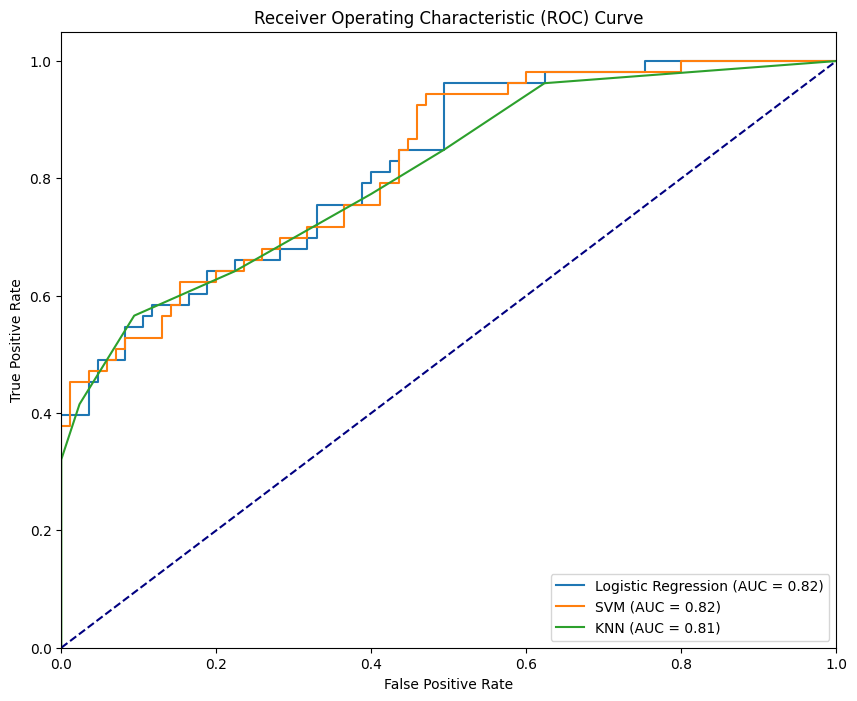

In [131]:
# 5. Plot ROC Curves for models that support it (Logistic Regression, SVM, KNN)
plt.figure(figsize=(10, 8))

# Store the best models obtained during hyperparameter tuning
best_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Hyperparameter tuning using GridSearchCV for each model
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        # Define hyperparameter grid
        if name == 'Logistic Regression':
            param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
        elif name == 'SVM':
            param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        elif name == 'KNN':
            param_grid = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}

        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_  # Make sure best_model is used
        best_models[name] = best_model # Store the best model
        print(f"Best Params for {name}: {grid_search.best_params_}")
    else:
        best_model = model.fit(X_train, y_train)
        best_models[name] = best_model # Store the best model


for name, model in best_models.items(): # Iterate through best_models instead of models
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        # Use the best fitted model to get probabilities for ROC curve
        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()